1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to graphically display the regions.
* Use `scipy.optimize.minimize()`, trying its optional arguments.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from IPython.display import display
from scipy.integrate import odeint

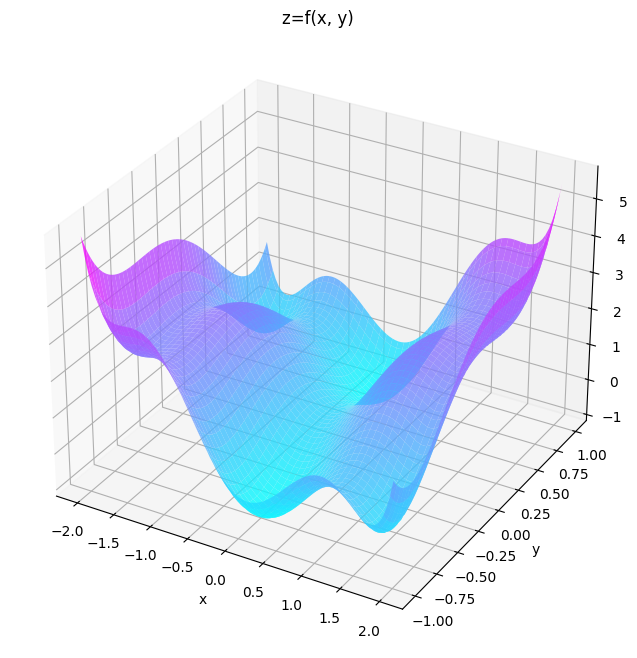

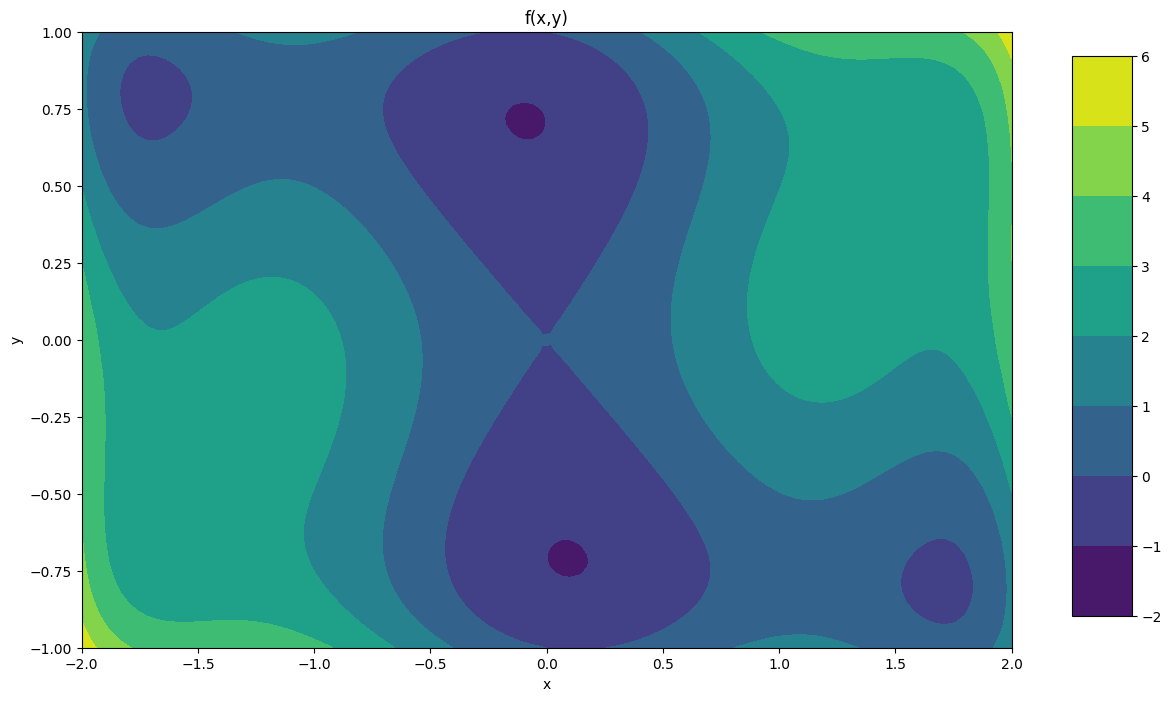

In [2]:
# plotting the function
def f(x):
    p1 = 4-2.1*x[0]**2+(x[0]**4)/3
    p2 = 4*(x[1]**2)-4
    return p1*x[0]**2 + x[0]*x[1] + p2*(x[1]**2)

x = np.linspace(-2, 2, 100)
y = np.linspace(-1, 1, 100)
xs, ys = np.meshgrid(x, y)

fig = plt.figure(figsize=[15, 8])
ax1 = fig.add_subplot(1,1,1, projection='3d')

# 3d plot of the function
ax1.plot_surface(xs, ys, f([xs, ys]), cmap='cool', alpha=0.8)
ax1.set_title('z=f(x, y)')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')

plt.show()

# 2D contour plot
fig, ax = plt.subplots(figsize=[12, 8])
cnt = ax.contourf(x, y, f([xs, ys]))
ax.set_title('f(x,y)')
cax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(cnt, cax=cax, orientation='vertical')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

the two absolute minima are:
x1: 0.08984202593058514 y1: -0.7126564022139154
x2: -0.08984203693665399 y2: 0.7126563929083877


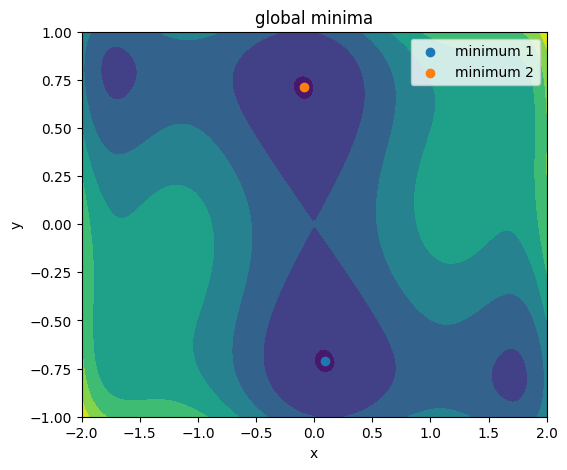

In [3]:
# find the points of minimum
bounds = ((-2, 2), (-1, 1))
min1 = optimize.minimize(f, (2, 0), bounds=bounds)
min2 = optimize.minimize(f, (-2, 0), bounds=bounds)

print("the two absolute minima are:")
print("x1:", min1.x[0], "y1:", min1.x[1])
print("x2:", min2.x[0], "y2:", min2.x[1])

fig, ax = plt.subplots(figsize=(6, 5))
ax.contourf(x, y, f([xs, ys]))
ax.scatter(min1.x[0], min1.x[1], label='minimum 1')
ax.scatter(min2.x[0], min2.x[1], label='minimum 2')
ax.legend()
ax.set_title('global minima')
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.show()

if we choose (0, 0) as starting point, however, we obtain as minimum the point
x: 0.0 y: 0.0
which, as we can see from the plot, is not an absolute minimum of the function.


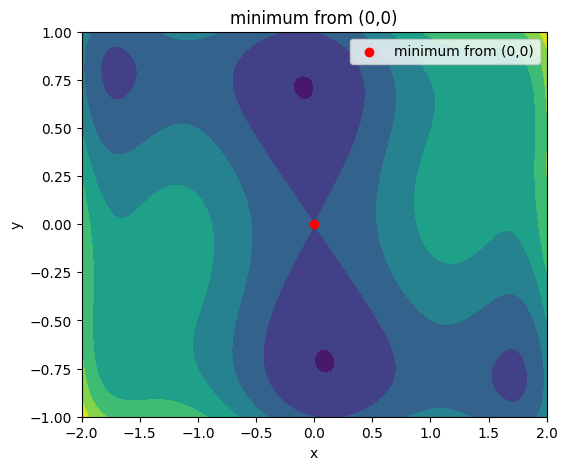

In [4]:
# calculate the minimum from starting point (0, 0)
minz = optimize.minimize(f, (0, 0), bounds=bounds)

print("if we choose (0, 0) as starting point, however, we obtain as minimum the point")
print("x:", minz.x[0], "y:", minz.x[1])
print("which, as we can see from the plot, is not an absolute minimum of the function.")

fig, ax = plt.subplots(figsize=(6,5))
ax.contourf(x, y, f([xs, ys]))
ax.scatter(minz.x[0], minz.x[1], color='r', label='minimum from (0,0)')
ax.legend()
ax.set_title('minimum from (0,0)')
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.show()

2\. **Non-linear ODE: the damped pendulum**

The equation of the motion of a forced pendulum, as a function of the angle $\theta$ with the vertical, is given by:

$$\frac{d^2\theta}{dt^2} = -\frac{1}{Q} \frac{d\theta}{dt} + \frac{g}{l}\sin\theta + d \cos\Omega t$$

where $t$ is time, $Q$ is the damping factor, $d$ is the forcing amplitude, and $\Omega$ is the driving frequency of the forcing. 

This second order ODE needs to be written as two coupled first order ODEs by defining a new variable $\omega \equiv d\theta/dt$:

$$\frac{d\theta}{dt} = \omega$$
$$\frac{d\omega}{dt} = -\frac{1}{Q}\,\omega + \frac{g}{l}\sin\theta + d \cos\Omega t$$

Consider the initial conditions $\theta_0 = \omega_0 = 0$, and $l = 10$, $Q = 2.0$, $d = 1.5$, and $\omega = 0.65$.

 - Solve the ODE with `odeint` over a period of 200 time steps
 - Create two plots, one of $\theta$ as a function of the time, and $\omega$ as a function of the time
 - **Optional**: determine if there is a set of parameters for which the motion is chaotic.

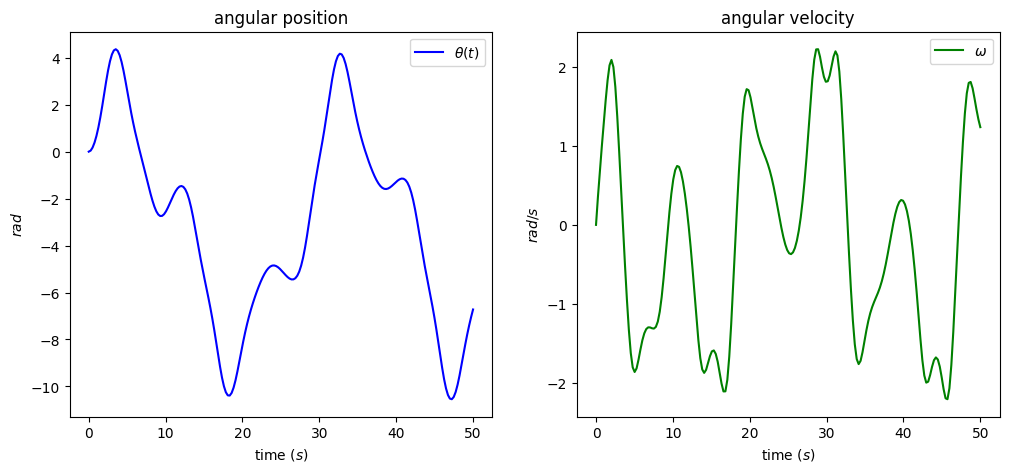

In [12]:

# initial conditions
theta0 = 0
w0 = 0

# variables
Q = 2
d = 1.5
w = 0.65

# define the function representing the differential equation
def derivative(X, time, Q, w, d):
    theta = X[0]
    omega = X[1]
    return (omega, ((-1)/Q)*omega + np.sin(theta) + d*np.cos(w*time))

# define the time over which we compute the solutions (200 steps)
t = np.linspace(0, 50, 200)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
ax[0].plot(t, results[:, 0], label='$\\theta(t)$', color='blue')
ax[1].plot(t, results[:, 1], label='$\omega$', color='green')
ax[0].set_xlabel('time ($s$)')
ax[1].set_xlabel('time ($s$)')
ax[0].set_ylabel('$rad$')
ax[1].set_ylabel('$rad/s$')
ax[0].set_title('angular position')
ax[1].set_title('angular velocity')
ax[0].legend()
ax[1].legend()
plt.show()


3\. **FFT of a simple dataset**

Perform a periodicity analysis on the lynxs-hares population, i.e. determine what is the period of the population of these animals.

The dataset is the one downloaded at the beginning of Lecture 06:

 - `!wget https://www.dropbox.com/s/ebe1cnyd2gm836a/populations.txt -P data/`

4\. **FFT of an image**

Write a filter that removes the periodic noise from the `moonlanding.png` image by using a 2-dimensional FFT.

* Import the image as a 2D numpy array using `plt.imread("images/moonlanding.png")`. Examine the image with `plt.imshow()`, which is heavily contaminated with periodic noise.
* Check the documentation of the `scipy.fftpack` package, and find the method that performs a 2D FFT. Plot the spectrum (Fourier transform of) the image. **Hint**: use `LogNorm` to plot the colors in log scale:
```Python
from matplotlib.colors import LogNorm
plt.imshow(image, norm=LogNorm(vmin=5))
```
* Inspect the spectrum, and try to locate the 2D regions of the power spectrum that contain the signal and those which contain the periodic noise. Use array slicing to set the noise regions to zero.
* Apply the inverse Fourier transform to plot the resulting image.